<h1>Capstone Project - The Battle of the Regions (Week 2)</h1>


<h2>Table of contents</h2>

* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

<h2>Introduction</h2><a name="introduction"></a>

It is well known that a separatist movement exists in French speaking Canada. Given the changing political climate gobally, political decision makers in Canada may want a better understanding of the phenomenon in order to tailor their election campaigns better, or for informing decision making when in office. The purpose of the project is to explore the nature and extent of cultural similarities and differences between English speaking Toronto and French speaking Quebec City, using the Foursquare API to uncover the patterns. The foreign cultural influences in the project are represented by venues in New York, London and Paris.
Possible outcomes are projected to be that
<ol>
<li>the two cities share a common Canadian identity more than they separated by foreign identities.</li>
    <li>the two cities are separated by foreign cultural identities.</li>
    <li>all cities in the study are more individual than similar when
        comparing them by top venues.</li>
<li>the two cities share a North American cultural identity with NY,
    with perhaps a predominance of fast food.</li>
<li>one of the cities is more individual, while the other has a
    stronger foreign cultural identity.</li>
<li>the cosmopolitan cities share a cultural identity compared to
    the provincial cities (Quebec City).</li>
</ol>

Although the population size of Montreal is more comparable to that of Toronto, it is also closer geographically and intuitively may not be representative of French speaking Canada as a whole as this article also suggests

https://www.vice.com/en_ca/article/exkmee/could-montreal-benefit-from-being-a-sovereign-city-state

The project will separately examine the influence of geographical proximity on the venue mix as a possible confounding factor, by comparing the venues of Montreal with those of Vancouver using a machine learning algorithm. 

<h2>Data</h2> <a name="data"></a>

The Foursquare API will be used in the project. Food is generally acknowledged as a representative expression of national culture, consequently the project will focus on food venues. The top 100 food venues in Toronto will be compared with the top 100 food venues in Quebec City, and each will also be compared with the top 100 food venues in New York, London and Paris. East Asian, African and South American venues will be grouped into continental categories in order to reduce possible outlier effects. In general only the highest level categories for the venues will be used, so for example "Burrito Place", "Taco Place" and "Tex-Mex Restaurant" will be grouped into their higher level Foursquare category "Mexican Restaurant". The city center latitudes and longitudes, as well as distances between cities will be obtained through the Python Geopy API.

The Foursquare city radius parameter must be as representative as possible, and should include a variety of neighborhoods. One way of determining this parameter is visual examination of the city centers with an application like Google Maps. It is assumed in this project, that the most representative food venues are clustered in the city center.

<h2>Methodology</h2> <a name="methodology"></a>

Considering the similarity metric to be used, when taking into account the relative frequency of venues between the cities undesirable confounding factors relating to city size may appear. As the project is purely focused on cultural differences between the cities, it is decided that relative venue frequency will be ignored in the analysis by employing the Jaccard index similarity metric. This similarity measure treats the data as sets of unique items. The results will be tabulated and also displayed in a heatmap.

When examining the city centers with the satellite view of Google Maps, it was found that 6 km seemed an appropriate uniform value for the radius parameter. From smallest to largest this seemed to approximate the center of Quebec City while also covering central London City (the latter presumably having far more high rise buildings). New York presented a slight challenge when defining the radius, as it is undesirable to have the business district of lower Manhattan overrepresented in the sample the radius was extended mostly due to New York. 

The food venue hierarchy of Foursquare is indicated in their API documentation

https://developer.foursquare.com/docs/resources/categories

and this will be flattened to include only the higher level categories, as discussed in the data section. Following this preprocessing step, the standard deviations will be examined to get an approximation of remaining data skew. 

<h2>Analysis</h2> <a name="analysis"></a>

<h3>Obtaining City Locations</h3>

First we get the latitudes and longitudes of the cities we are investigating, using the Python Geopy API. These will be used for calling the Foursquare API later.

In [4]:
import requests
from geopy.geocoders import Nominatim
from geopy.distance import vincenty

def get_coordinates(address):
    try:
        geolocator = Nominatim(user_agent="coursera_explorer")
        location = geolocator.geocode(address)
        lat = location.latitude
        lon = location.longitude
        return [lat, lon]
    except:
        return [None, None]
    
address = 'Toronto, Ontario'
toronto = get_coordinates(address)
print('The geograpical coordinate of Toronto are {}, {}.'.format(toronto[0], toronto[1]))
address = 'Quebec City, Quebec'
quebec = get_coordinates(address)
print('The geograpical coordinate of Quebec City are {}, {}.'.format(quebec[0], quebec[1]))
address = 'New York, NY'
new_york = get_coordinates(address)
print('The geograpical coordinate of New York are {}, {}.'.format(new_york[0], new_york[1]))
address = 'London, UK'
london = get_coordinates(address)
print('The geograpical coordinate of London are {}, {}.'.format(london[0], london[1]))
address = 'Paris, France'
paris = get_coordinates(address)
print('The geograpical coordinate of Paris are {}, {}.'.format(paris[0], paris[1]))
address = 'Montreal, Quebec'
montreal = get_coordinates(address)
print('The geograpical coordinate of Montreal are {}, {}.'.format(montreal[0], montreal[1]))
address = 'Vancouver, BC'
vancouver = get_coordinates(address)
print('The geograpical coordinate of Vancouver are {}, {}.'.format(vancouver[0], vancouver[1]))

The geograpical coordinate of Toronto are 43.653963, -79.387207.
The geograpical coordinate of Quebec City are 46.8259601, -71.2352226.
The geograpical coordinate of New York are 40.7308619, -73.9871558.
The geograpical coordinate of London are 51.5073219, -0.1276474.
The geograpical coordinate of Paris are 48.8566101, 2.3514992.
The geograpical coordinate of Montreal are 45.4972159, -73.6103642.
The geograpical coordinate of Vancouver are 49.2608724, -123.1139529.


<h3>Obtaining venues</h3>

Subsequently we call the Foursquare with the parameters 6 km radius and 100 limit, in order to get the top food venue categories for each city.

In [5]:
import json
import pandas as pd
import numpy as np

credentials = json.load(open('foursquare.json'))
CLIENT_ID = credentials['CLIENT_ID'] # your Foursquare ID
CLIENT_SECRET = credentials['CLIENT_SECRET'] # your Foursquare Secret


def getNearbyVenues(latitude, longitude, radius=6000, LIMIT=100):
    VERSION = '20180605'
    search_query = 'Food'

    venues_list=[]            
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&query={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        search_query,
        LIMIT)
            
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
        
    # return only category for each venue
    for v in results:    
        for c in v['venue']['categories']:
            venues_list.append( c['name'] )

    dataframe = pd.DataFrame({'Category':venues_list})            
            
    return(dataframe)

toronto_df = getNearbyVenues(toronto[0],toronto[1])
quebec_df = getNearbyVenues(quebec[0],quebec[1])
newyork_df = getNearbyVenues(new_york[0],new_york[1])
london_df = getNearbyVenues(london[0],london[1])
paris_df = getNearbyVenues(paris[0],paris[1])
montreal_df = getNearbyVenues(montreal[0],montreal[1])
vancouver_df = getNearbyVenues(vancouver[0],vancouver[1])
toronto_df.head(10)

,Category
0,Thai Restaurant
1,Mediterranean Restaurant
2,Gastropub
3,Sushi Restaurant
4,American Restaurant
5,Steakhouse
6,Sandwich Place
7,Sushi Restaurant
8,Japanese Restaurant
9,Breakfast Spot


<h3>Reducing feature space</h3>

Next we need to parse the data in order to include only the highest level categories, going by the food venue category tree in the Foursquare documentation.

In [6]:
def parseCategories(dataframe):
    dataframe.replace("Ethiopian Restaurant", "African Restaurant",inplace=True)
    dataframe.replace("New American Restaurant", "American Restaurant",inplace=True)    
    dataframe.replace(["Burmese Restaurant","Cambodian Restaurant","Chinese Restaurant","Cantonese Restaurant","Cha Chaan Teng","Dim Sum Restaurant","Szechuan Restaurant","Filipino Restaurant","Himalayan Restaurant","Dongbei Restaurant","Fujian Restaurant","Hakka Restaurant","Hunan Restaurant","Peking Duck Restaurant","Shanghai Restaurant","Taiwanese Restaurant","Xinjiang Restaurant","Hotpot Restaurant","Indonesian Restaurant"], "Asian Restaurant",inplace=True) 
    dataframe.replace(["Japanese Restaurant","Ramen Restaurant","Shabu-Shabu Restaurant","Soba Restaurant","Sushi Restaurant","Udon Restaurant","Korean Restaurant","Malay Restaurant","Mongolian Restaurant","Noodle House","Satay Restaurant","Thai Restaurant","Tibetan Restaurant","Vietnamese Restaurant"], "Asian Restaurant",inplace=True)   
    dataframe.replace("Cuban Restaurant", "Caribbean Restaurant",inplace=True)   
    dataframe.replace(["Cupcake Shop","Frozen Yogurt Shop","Ice Cream Shop","Pastry Shop","Pie Shop"], "Dessert Shop",inplace=True)   
    dataframe.replace(["Bosnian Restaurant","Bulgarian Restaurant","Romanian Restaurant"], "Eastern European Restaurant",inplace=True)   
    dataframe.replace(["Alsatian Restaurant","Auvergne Restaurant","Basque Restaurant","Brasserie","Breton Restaurant","Burgundian Restaurant","Catalan Restaurant","Ch'ti Restaurant","Corsican Restaurant","Estaminet","Labour Canteen","Lyonese Bouchon","Norman Restaurant","Provençal Restaurant","Savoyard Restaurant","Southwestern French Restaurant"], "French Restaurant",inplace=True)   
    dataframe.replace("Souvlaki Shop", "Greek Restaurant",inplace=True)
    dataframe.replace("Poke Place", "Hawaiian Restaurant",inplace=True)
    dataframe.replace(["Chaat Place","Dosa Place","Indian Chinese Restaurant","North Indian Restaurant","South Indian Restaurant"], "Indian Restaurant",inplace=True)   
    dataframe.replace("Kosher Restaurant", "Jewish Restaurant",inplace=True)
    dataframe.replace(["Arepa Restaurant","Empanada Restaurant","Salvadoran Restaurant","South American Restaurant","Argentinian Restaurant","Brazilian Restaurant","Colombian Restaurant","Peruvian Restaurant","Venezuelan Restaurant"], "Latin American Restaurant",inplace=True)   
    dataframe.replace("Moroccan Restaurant", "Mediterranean Restaurant",inplace=True)
    dataframe.replace(["Burrito Place","Taco Place","Tex-Mex Restaurant"], "Mexican Restaurant",inplace=True)   
    dataframe.replace(["Egyptian Restaurant","Iraqi Restaurant","Israeli Restaurant","Kurdish Restaurant","Lebanese Restaurant","Persian Restaurant","Shawarma Place","Syrian Restaurant","Yemeni Restaurant"], "Middle Eastern Restaurant",inplace=True)   
    dataframe.replace(["Paella Restaurant","Tapas Restaurant"], "Spanish Restaurant",inplace=True)   
    dataframe.replace("Doner Restaurant", "Turkish Restaurant",inplace=True)
    
parseCategories(toronto_df)
parseCategories(quebec_df)
parseCategories(newyork_df)
parseCategories(london_df)
parseCategories(paris_df)
parseCategories(montreal_df)
parseCategories(vancouver_df)
toronto_df.head(10)

,Category
0,Asian Restaurant
1,Mediterranean Restaurant
2,Gastropub
3,Asian Restaurant
4,American Restaurant
5,Steakhouse
6,Sandwich Place
7,Asian Restaurant
8,Asian Restaurant
9,Breakfast Spot


<h3>Statistical Analysis</h3>

Now that only the highest level categories are included, we will look at the standard deviations to see if some data skew remains.

In [7]:
toronto_df.groupby('Category').size().reset_index(name='Count').describe(include='all')

,Category,Count
count,31,31.000000
unique,31,NaN
top,Mexican Restaurant,NaN
freq,1,NaN
mean,NaN,3.225806
std,NaN,3.879086
min,NaN,1.000000
25%,NaN,1.000000
50%,NaN,1.000000
75%,NaN,4.000000


In [8]:
quebec_df.groupby('Category').size().reset_index(name='Count').describe(include='all')

,Category,Count
count,29,29.000000
unique,29,NaN
top,Asian Restaurant,NaN
freq,1,NaN
mean,NaN,3.448276
std,NaN,4.687264
min,NaN,1.000000
25%,NaN,1.000000
50%,NaN,1.000000
75%,NaN,3.000000


In [9]:
newyork_df.groupby('Category').size().reset_index(name='Count').describe(include='all')

,Category,Count
count,26,26.000000
unique,26,NaN
top,Mexican Restaurant,NaN
freq,1,NaN
mean,NaN,3.846154
std,NaN,5.065114
min,NaN,1.000000
25%,NaN,1.000000
50%,NaN,2.000000
75%,NaN,4.000000


In [10]:
london_df.groupby('Category').size().reset_index(name='Count').describe(include='all')

,Category,Count
count,29,29.000000
unique,29,NaN
top,Mexican Restaurant,NaN
freq,1,NaN
mean,NaN,3.448276
std,NaN,3.397333
min,NaN,1.000000
25%,NaN,1.000000
50%,NaN,3.000000
75%,NaN,4.000000


In [11]:
paris_df.groupby('Category').size().reset_index(name='Count').describe(include='all')

,Category,Count
count,24,24.000000
unique,24,NaN
top,Bistro,NaN
freq,1,NaN
mean,NaN,4.166667
std,NaN,5.386510
min,NaN,1.000000
25%,NaN,1.000000
50%,NaN,3.000000
75%,NaN,4.250000


In [12]:
montreal_df.groupby('Category').size().reset_index(name='Count').describe(include='all')

,Category,Count
count,28,28.000000
unique,28,NaN
top,Mexican Restaurant,NaN
freq,1,NaN
mean,NaN,3.571429
std,NaN,4.211348
min,NaN,1.000000
25%,NaN,2.000000
50%,NaN,2.500000
75%,NaN,4.000000


In [13]:
vancouver_df.groupby('Category').size().reset_index(name='Count').describe(include='all')

,Category,Count
count,26,26.000000
unique,26,NaN
top,Mexican Restaurant,NaN
freq,1,NaN
mean,NaN,3.846154
std,NaN,4.026833
min,NaN,1.000000
25%,NaN,1.000000
50%,NaN,2.500000
75%,NaN,4.000000


<h3>Measuring Similarity</h3>

The various standard deviations are judged to be within an acceptable range when accounting for inherent differences between the cities. The next step is building the similarity matrix with the Jaccard scores and visualizing it.

In [14]:
from sklearn.metrics import jaccard_similarity_score

matrix = pd.DataFrame(columns=['Toronto','Quebec','New York','London','Paris'],index=['Toronto','Quebec','New York','London','Paris'])
matrix.loc['Toronto','Quebec'] = matrix.loc['Quebec','Toronto'] = jaccard_similarity_score(toronto_df, quebec_df)
matrix.loc['Toronto','New York'] = matrix.loc['New York','Toronto'] = jaccard_similarity_score(toronto_df, newyork_df)
matrix.loc['Toronto','Paris'] = matrix.loc['Paris','Toronto'] = jaccard_similarity_score(toronto_df, paris_df)
matrix.loc['Toronto','London'] = matrix.loc['London','Toronto'] = jaccard_similarity_score(toronto_df, london_df)
matrix.loc['Toronto','Toronto'] = 0
matrix.loc['Quebec','New York'] = matrix.loc['New York','Quebec'] = jaccard_similarity_score(quebec_df, newyork_df)
matrix.loc['Quebec','Paris'] = matrix.loc['Paris','Quebec'] = jaccard_similarity_score(quebec_df, paris_df)
matrix.loc['Quebec','London'] = matrix.loc['London','Quebec'] = jaccard_similarity_score(quebec_df, london_df)
matrix.loc['Quebec','Quebec'] = 0
matrix.loc['New York','Paris'] = matrix.loc['Paris','New York'] = jaccard_similarity_score(newyork_df, paris_df)
matrix.loc['New York','London'] = matrix.loc['London','New York'] = jaccard_similarity_score(newyork_df, london_df)
matrix.loc['New York','New York'] = 0
matrix.loc['London','Paris'] = matrix.loc['Paris','London'] = jaccard_similarity_score(london_df, paris_df)
matrix.loc['London','London'] = 0
matrix.loc['Paris','Paris'] = 0
matrix = matrix.astype(np.float)
matrix

,Toronto,Quebec,New York,London,Paris
Toronto,0.00,0.05,0.11,0.01,0.06
Quebec,0.05,0.00,0.04,0.04,0.09
New York,0.11,0.04,0.00,0.01,0.04
London,0.01,0.04,0.01,0.00,0.07
Paris,0.06,0.09,0.04,0.07,0.00


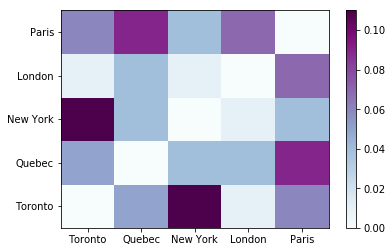

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline 

fig, ax = plt.subplots()
im = ax.pcolor(matrix, cmap='BuPu')

#label names
row_labels = matrix.columns
col_labels = matrix.index

#insert labels
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(col_labels, minor=False)

#move ticks and labels to the center
ax.set_xticks(np.arange(matrix.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0]) + 0.5, minor=False)

fig.colorbar(im)
plt.show()

On initial inspection, there appears to be a relatively high similarity between the cities of Toronto and New York, Quebec and Paris, as well as Toronto and Quebec. This does not exactly fit any of our preconceived scenarios, as discussed in the Introduction, so we analyse it later.

<h3>Geographic location and venue mix</h3>

The possibility of geographic proximity influencing the venues of a city remains to be investigated, as mentioned in the Introduction. We will predict the venues of Montreal using the combined venues of Toronto, Quebec City and New York using Random Forest. The city distances to Montreal will be averaged and included in the exercise.

In [97]:
m1 = toronto_df.groupby('Category').size().reset_index(name='Count')
dist = vincenty((toronto[0],toronto[1]), (montreal[0],   montreal[1])).kilometers
m1['Distance'] = dist
m1['Count'] = m1['Count'].astype(np.float)
m1['Distance'] = m1['Distance'].astype(np.float)
m2 = newyork_df.groupby('Category').size().reset_index(name='Count')
dist = vincenty((new_york[0],new_york[1]), (montreal[0],   montreal[1])).kilometers
m2['Distance'] = dist
m2['Count'] = m2['Count'].astype(np.float)
m2['Distance'] = m2['Distance'].astype(np.float)
m3 = quebec_df.groupby('Category').size().reset_index(name='Count')
dist = vincenty((quebec[0],quebec[1]), (montreal[0],   montreal[1])).kilometers
m3['Distance'] = dist
m3['Count'] = m3['Count'].astype(np.float)
m3['Distance'] = m3['Distance'].astype(np.float)
merge_df = pd.concat([m1, m2, m3], axis=0)
merge_df = merge_df.groupby('Category').agg({'Count':'sum','Distance':'mean'}).reset_index()
merge_df


,Category,Count,Distance
0,American Restaurant,13.0,422.740539
1,Asian Restaurant,44.0,422.740539
2,Australian Restaurant,1.0,530.403565
3,BBQ Joint,3.0,422.740539
4,Bagel Shop,3.0,382.950489
5,Bakery,11.0,422.740539
6,Bistro,2.0,235.497413
7,Breakfast Spot,4.0,368.909025
8,Buffet,1.0,235.497413
9,Burger Joint,6.0,422.740539


Next we will aggegrate the Montreal venues, to be used later as values to be predicted.

In [99]:
test1_df = montreal_df.groupby('Category').size().reset_index(name='Count')
test1_df['Count'] = test1_df['Count'].astype(np.float)
test1_df = test1_df.groupby('Category').sum().reset_index()
test1_df

,Category,Count
0,Asian Restaurant,9.0
1,BBQ Joint,2.0
2,Bagel Shop,2.0
3,Bakery,5.0
4,Breakfast Spot,1.0
5,Burger Joint,2.0
6,Café,23.0
7,Deli / Bodega,3.0
8,Diner,1.0
9,Dumpling Restaurant,2.0


Since we want identical feature space for the machine learning algorithm, we will limit the examination to only those venues existing in the merged set. We do this by performing a right join with the Montreal set and setting NaN values to zero. 

In [104]:
training_df = test1_df.merge(merge_df, on='Category', how='right')
training_df.fillna(0, inplace=True)
training_df

,Category,Count_x,Count_y,Distance
0,Asian Restaurant,9.0,44.0,422.740539
1,BBQ Joint,2.0,3.0,422.740539
2,Bagel Shop,2.0,3.0,382.950489
3,Bakery,5.0,11.0,422.740539
4,Breakfast Spot,1.0,4.0,368.909025
5,Burger Joint,2.0,6.0,422.740539
6,Café,23.0,28.0,422.740539
7,Deli / Bodega,3.0,3.0,382.950489
8,Diner,1.0,3.0,368.909025
9,French Restaurant,3.0,25.0,422.740539


The categorical data needs to be one-hot encoded, by calling pandas get_dummies.

In [105]:
features = training_df[['Count_x','Count_y','Distance']]
features = pd.concat([features,pd.get_dummies(training_df['Category'])], axis=1)
features

,Count_x,Count_y,Distance,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,...,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Snack Place,Soup Place,Spanish Restaurant,Steakhouse,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,9.0,44.0,422.740539,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,3.0,422.740539,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,3.0,382.950489,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5.0,11.0,422.740539,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,4.0,368.909025,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2.0,6.0,422.740539,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,23.0,28.0,422.740539,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3.0,3.0,382.950489,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1.0,3.0,368.909025,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3.0,25.0,422.740539,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The labels to be predicted, which consist of remaining Montreal venue counts, are separated from the data. 

In [106]:
# Labels are the values we want to predict
labels = np.array(features['Count_x'])
# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('Count_x', axis = 1)
features

,Count_y,Distance,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,...,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Snack Place,Soup Place,Spanish Restaurant,Steakhouse,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,44.0,422.740539,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.0,422.740539,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,382.950489,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11.0,422.740539,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.0,368.909025,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,6.0,422.740539,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,28.0,422.740539,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3.0,382.950489,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,3.0,368.909025,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,25.0,422.740539,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next create the training and test sets with the train_test_split method, and ensure the column count is the same. 

In [107]:
from sklearn.model_selection import train_test_split

# Convert to numpy array
features = np.array(features)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (33, 47)
Training Labels Shape: (33,)
Testing Features Shape: (12, 47)
Testing Labels Shape: (12,)


From a review of machine learning algorithms, it was determined that Random Forest is less sensitive to parameter values than others like SVM or KNN. It is undesirable to optimize parameters on the Montreal data, since the prediction will be used to test the hypothesis of geographic proximity instead of building a reuseable model as in a normal machine learning application. Therefore the exercise will use a Random Forest classifier.

In [108]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [109]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 2.25


With the mean error for the Montreal data obtained, we will next focus on the Vancouver data. We will do the identical transformations as above, first obtaining the new city distances to Vancouver. 

In [110]:
m1 = toronto_df.groupby('Category').size().reset_index(name='Count')
dist = vincenty((toronto[0],toronto[1]), (vancouver[0],   vancouver[1])).kilometers
m1['Distance'] = dist
m1['Count'] = m1['Count'].astype(np.float)
m1['Distance'] = m1['Distance'].astype(np.float)
m2 = newyork_df.groupby('Category').size().reset_index(name='Count')
dist = vincenty((new_york[0],new_york[1]), (vancouver[0],   vancouver[1])).kilometers
m2['Distance'] = dist
m2['Count'] = m2['Count'].astype(np.float)
m2['Distance'] = m2['Distance'].astype(np.float)
m3 = quebec_df.groupby('Category').size().reset_index(name='Count')
dist = vincenty((quebec[0],quebec[1]), (vancouver[0],   vancouver[1])).kilometers
m3['Distance'] = dist
m3['Count'] = m3['Count'].astype(np.float)
m3['Distance'] = m3['Distance'].astype(np.float)
merge_df = pd.concat([m1, m2, m3], axis=0)
merge_df = merge_df.groupby('Category').agg({'Count':'sum','Distance':'mean'}).reset_index()
merge_df

,Category,Count,Distance
0,American Restaurant,13.0,3694.437547
1,Asian Restaurant,44.0,3694.437547
2,Australian Restaurant,1.0,3914.520573
3,BBQ Joint,3.0,3694.437547
4,Bagel Shop,3.0,3857.823364
5,Bakery,11.0,3694.437547
6,Bistro,2.0,3801.126154
7,Breakfast Spot,4.0,3584.396034
8,Buffet,1.0,3801.126154
9,Burger Joint,6.0,3694.437547


In [111]:
test2_df = vancouver_df.groupby('Category').size().reset_index(name='Count')
test2_df['Count'] = test2_df['Count'].astype(np.float)
test2_df = test2_df.groupby('Category').sum().reset_index()
test2_df

,Category,Count
0,Asian Restaurant,19.0
1,BBQ Joint,3.0
2,Bagel Shop,1.0
3,Bakery,9.0
4,Belgian Restaurant,2.0
5,Breakfast Spot,2.0
6,Café,8.0
7,Deli / Bodega,1.0
8,Diner,1.0
9,French Restaurant,4.0


In [113]:
training2_df = test2_df.merge(merge_df, on='Category', how='right')
training2_df.fillna(0,inplace=True)
training2_df

,Category,Count_x,Count_y,Distance
0,Asian Restaurant,19.0,44.0,3694.437547
1,BBQ Joint,3.0,3.0,3694.437547
2,Bagel Shop,1.0,3.0,3857.823364
3,Bakery,9.0,11.0,3694.437547
4,Breakfast Spot,2.0,4.0,3584.396034
5,Café,8.0,28.0,3694.437547
6,Deli / Bodega,1.0,3.0,3857.823364
7,Diner,1.0,3.0,3584.396034
8,French Restaurant,4.0,25.0,3694.437547
9,Gastropub,3.0,13.0,3584.396034


In [114]:
test_features = training2_df[['Count_x','Count_y','Distance']]
test_features = pd.concat([test_features,pd.get_dummies(training2_df['Category'])], axis=1)
test_features

,Count_x,Count_y,Distance,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,...,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Snack Place,Soup Place,Spanish Restaurant,Steakhouse,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,19.0,44.0,3694.437547,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.0,3.0,3694.437547,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,3.0,3857.823364,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9.0,11.0,3694.437547,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,4.0,3584.396034,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,8.0,28.0,3694.437547,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1.0,3.0,3857.823364,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1.0,3.0,3584.396034,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4.0,25.0,3694.437547,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3.0,13.0,3584.396034,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [115]:
# Labels are the values we want to predict
test_labels = np.array(test_features['Count_x'])
# Remove the labels from the features
# axis 1 refers to the columns
test_features= test_features.drop('Count_x', axis = 1)
test_features

,Count_y,Distance,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,...,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Snack Place,Soup Place,Spanish Restaurant,Steakhouse,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,44.0,3694.437547,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.0,3694.437547,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,3857.823364,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11.0,3694.437547,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.0,3584.396034,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,28.0,3694.437547,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,3.0,3857.823364,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3.0,3584.396034,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,25.0,3694.437547,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,13.0,3584.396034,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 1.36


We obtained a more accurate prediction for the test set of Vancouver, than for the training set of Montreal. This surprising result would appear to invalidate our initial supposition that the venue mix correlates strongly with geographical proximity. Exploring deeper, we see that the Jaccard similarity score for Vancouver and New York is in the same range as the score for Toronto, while it is substantially lower for Montreal.

In [119]:
jaccard_similarity_score(vancouver_df,newyork_df)

0.1

In [120]:
jaccard_similarity_score(montreal_df,newyork_df)

0.05

One plausible explanation for the data, is that generally speaking Quebec City (and to a lesser degree Montreal) has a similar profile to Paris, whereas Toronto and Vancouver have a significant presence of international American restaurant chains accounting for their higher than average similarity to New York.
Therefore a compromise between the initial theories 
1. the two cities share a common Canadian identity more than they separated by foreign identities.
2. the two cities are separated by foreign cultural identities.
4. the two cities share a North American cultural identity with NY, with perhaps a predominance of fast food.

However examining the Toronto and Vancouver data in detail does not find strong evidence for the presence of American restaurant or fast food chains.

In [121]:
toronto_df.groupby('Category').size().reset_index(name='Count')

,Category,Count
0,American Restaurant,3
1,Asian Restaurant,17
2,BBQ Joint,1
3,Bakery,4
4,Breakfast Spot,2
5,Burger Joint,1
6,Café,15
7,Caribbean Restaurant,1
8,Comfort Food Restaurant,1
9,Creperie,1


The Café feature is somewhat ambigious, since at least Starbucks is an international American chain belonging in the category. However it is lower for Vancouver (which is closer to the global headquarters of Starbucks) than for Toronto.

In [122]:
vancouver_df.groupby('Category').size().reset_index(name='Count')

,Category,Count
0,Asian Restaurant,19
1,BBQ Joint,3
2,Bagel Shop,1
3,Bakery,9
4,Belgian Restaurant,2
5,Breakfast Spot,2
6,Café,8
7,Deli / Bodega,1
8,Diner,1
9,French Restaurant,4


<h2>Results and Discussion</h2> <a name="results"></a>
    
The analysis indicates that while the cities of Toronto and Quebec share a Canadian identity, they are at the same time also separated by stronger foreign identities when measuring by culinary venues and culture. The foreign influence appears to be cultural and linguistic rather than commercial.

Unlike other former colonies, the country has not had a unifying independence movement (many early immigrants were actually former loyalists from the revolutionary war in the USA) and therefore the country's linguistic regions are perhaps more influenced by foreign culinary cultures than the norm. Nationalism is perhaps also expressed to some degree in terms of region in preference to country, analogous to the conditions existing in the USA prior to the Civil War. However such conclusions would need further study.

<h2>Conclusion</h2> <a name="conclusion"></a>

The conclusion drawn from the data is that Quebec City and Toronto appear to have a dual nature, a weaker shared Canadian identity existing alongside divergent and perhaps competing foreign cultural profiles. Their similarity with foreign venues is higher than those of the average formed by New York, London and Paris. Quebec City is divided between Paris and Toronto in it's cultural makeup, whereas Toronto (along with Vancouver) has a similarity with New York which exceeds all other measurements. 

Political stakeholders in Canada may perhaps benefit from realizing, that it does not appear to be merely a question of separatists in Quebec but a country seemingly pulling in two different directions. They may want to take measures to reinforce a common Canadian identity in the area of sports or similar ventures. Separatist polticians on the other hand, perhaps would benefit from including an anti-American element to their electoral campaigns.